In [1]:
import math 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import torch.optim as optim
import os


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from time import time

import warnings

import random

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action = 'ignore')

In [2]:
SEED = 123
def seed_everything(seed=123):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
seed_everything(SEED)

In [3]:
device = 'cuda'

In [4]:
def load_data_1m(path='./', delimiter='::', frac=0.1, seed=1234):

    tic = time()
    print('reading data...')
    data = np.loadtxt(path+'ratings.dat', skiprows=0, delimiter=delimiter, encoding='latin-1').astype('int32')
    print(data)
#     print(data[data[:,2] == 0])
    print('taken', time() - tic, 'seconds')

    n_u = np.unique(data[:,0]).size  # num of users
    n_m = np.unique(data[:,1]).size  # num of movies
    n_r = data.shape[0]  # num of ratings

    udict = {}
    for i, u in enumerate(np.unique(data[:,0]).tolist()):
        udict[u] = i
    mdict = {}
    for i, m in enumerate(np.unique(data[:,1]).tolist()):
        mdict[m] = i

    np.random.seed(seed)
    idx = np.arange(n_r)
    np.random.shuffle(idx)

    train_r = np.zeros((n_m, n_u), dtype='float32')
    test_r = np.zeros((n_m, n_u), dtype='float32')
    train_user = []
    train_item = []
    train_rating = []
    test_user = []
    test_item = []
    test_rating = []
    
    for i in range(n_r):
        u_id = data[idx[i], 0]
        m_id = data[idx[i], 1]
        r = data[idx[i], 2]

        if i < int(frac * n_r):
            test_r[mdict[m_id], udict[u_id]] = r
            test_user.append(udict[u_id])
            test_item.append(mdict[m_id])
            test_rating.append(r)
            
        else:
            train_r[mdict[m_id], udict[u_id]] = r
            train_user.append(udict[u_id])
            train_item.append(mdict[m_id])
            train_rating.append(r)

    train_m = np.greater(train_r, 1e-12).astype('float32')  # masks indicating non-zero entries
    test_m = np.greater(test_r, 1e-12).astype('float32')
    train_user = np.array(train_user).astype('float32') 
    train_item = np.array(train_item).astype('float32')
    train_rating = np.array(train_rating).astype('float32')
    test_user = np.array(test_user).astype('float32') 
    test_item = np.array(test_item).astype('float32') 
    test_rating = np.array(test_rating).astype('float32')
    
    
    
    print('data matrix loaded')
    print('num of users: {}'.format(n_u))
    print('num of movies: {}'.format(n_m))
    print('num of training ratings: {}'.format(n_r - int(frac * n_r)))
    print('num of test ratings: {}'.format(int(frac * n_r)))

    return n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating

In [5]:
path = '/Linux/Data/recommendation/ml-1m/'
n_m, n_u, train_r, train_m, test_r, test_m, train_user, train_item, train_rating, test_user, test_item, test_rating = load_data_1m(path=path, delimiter='::', frac=0.1, seed=1234)


reading data...
[[        1      1193         5 978300760]
 [        1       661         3 978302109]
 [        1       914         3 978301968]
 ...
 [     6040       562         5 956704746]
 [     6040      1096         4 956715648]
 [     6040      1097         4 956715569]]
taken 5.376123428344727 seconds
data matrix loaded
num of users: 6040
num of movies: 3706
num of training ratings: 900189
num of test ratings: 100020


In [6]:
items = torch.LongTensor(train_item)
users = torch.LongTensor(train_user)
ratings = torch.FloatTensor(train_rating)
items_test = torch.LongTensor(test_item)
users_test = torch.LongTensor(test_user)
ratings_test = torch.FloatTensor(test_rating)

In [7]:
train_1 = pd.read_csv('../ml-100k/ua.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_1 = pd.read_csv('../ml-100k/ua.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
train_2 = pd.read_csv('../ml-100k/ub.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_2 = pd.read_csv('../ml-100k/ub.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])

In [8]:
len(items), len(users), len(ratings)

(900189, 900189, 900189)

In [9]:
# rank = 10

numItems = 3706
numUsers = 6040

# P = torch.randn(numItems, rank, requires_grad=True)
# Q = torch.randn(numUsers, rank, requires_grad=True)

In [10]:
n_gaussians = 1
# n_hidden = 128
rank = 20
# reg_p = [1/n_gaussians] * n_gaussians
# reg_p = [0.8, 0.2]

In [11]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

In [12]:
def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * F.softmax(pi)
    result = torch.sum(result, dim=1)
    result = -torch.log(result+ 1e-6)
    return torch.mean(result)

In [13]:
# def regularization(p, k):
#     minus = torch.zeros(1,k)
#     result = []
#     for i in range(k):
#         minus[:,i] = 1
#         result.append(torch.mean(F.softmax(p), axis = 0) - minus)
#         minus = torch.zeros(1,k)
#     result = torch.sum(torch.square(torch.cat(result)))
#     return result

In [14]:
def regularization(p, k):
    result = torch.mean(F.softmax(p), axis = 0) - torch.Tensor(k).to(device)
    result = torch.sum(torch.square(result))
    return result

In [15]:
import torch
import torch.nn as nn

class PosLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(PosLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn((in_dim, out_dim)))
        self.bias = nn.Parameter(torch.zeros((out_dim,)))
        
    def forward(self, x):
        return torch.matmul(x, torch.abs(self.weight)) + torch.abs(self.bias)

In [16]:
layers_mean = PosLinear(rank, n_gaussians).to(device)
# layers_mean = nn.Sequential(
#             nn.Linear(rank, 128),
#             nn.Tanh(),
#             nn.Linear(128, n_gaussians)
# ).to(device)
# layers_mean = nn.Sequential(
#             PosLinear(rank, 128),
#             PosLinear(128, n_gaussians)
# ).to(device)
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)


In [17]:
Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [18]:
P.shape, Q.shape

(torch.Size([3706, 20]), torch.Size([6040, 20]))

In [19]:
# lambda1 = 0.0001
# lambda2 = 0.0001
# lambda3 = 0.1
# optimizer_P = torch.optim.Adam([P] + list(layers_mean.parameters()), lr= 1e-3)
# optimizer_Q = torch.optim.Adam([Q] + list(layers_mean.parameters()), lr= 1e-3)

In [20]:
# bias_item = torch.randn(numItems, requires_grad = True)
# bias_user = torch.randn(numUsers, requires_grad = True)

In [21]:
# mean = (ratings.sum()/len(ratings)).item()

In [22]:
bi = torch.nn.Parameter(torch.randn(numItems, requires_grad = True))
bu = torch.nn.Parameter(torch.randn(numUsers, requires_grad = True))

In [23]:
train_r1 = np.where(train_r == 0, 0, 1)
train_r2 = torch.from_numpy(train_r1)

In [24]:
mean = (ratings.sum()/len(ratings)).item()

In [25]:
y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2).to(device)

In [26]:
nu_y = torch.matmul(y_norm.unsqueeze(1).T, Y)

In [27]:
pnu = (P[items] + nu_y).sum(axis = 1)

In [28]:
pnu_test = (P[items_test] + nu_y).sum(axis = 1)

epoch: 0, train cost_P 4.504591, train cost: 2.122402, test cost: 2.114930, minimum test cost: 2.114930
means of test groups: tensor([[5.4080],
        [3.7999],
        [5.2008],
        [5.8029],
        [4.5002]], device='cuda:0')
ratings of test groups: tensor([4., 5., 4., 3., 3.])


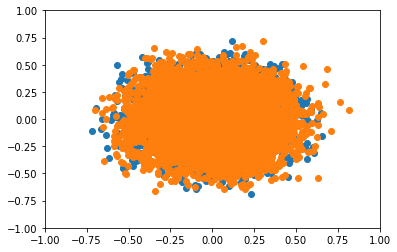

epoch: 100, train cost_P 3.830265, train cost: 1.957106, test cost: 1.950362, minimum test cost: 1.950362
means of test groups: tensor([[5.3808],
        [5.6749],
        [5.1824],
        [4.9275],
        [4.7284]], device='cuda:0')
ratings of test groups: tensor([2., 5., 3., 3., 1.])


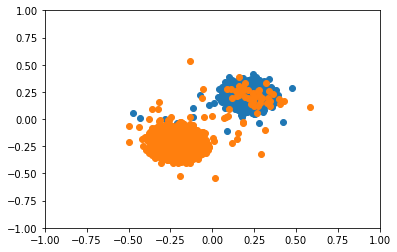

epoch: 200, train cost_P 3.307095, train cost: 1.818542, test cost: 1.812805, minimum test cost: 1.812805
means of test groups: tensor([[6.0728],
        [4.4289],
        [3.4340],
        [3.7013],
        [5.7913]], device='cuda:0')
ratings of test groups: tensor([3., 3., 3., 3., 4.])


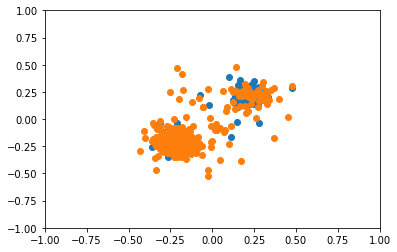

epoch: 300, train cost_P 2.900240, train cost: 1.703009, test cost: 1.698524, minimum test cost: 1.698524
means of test groups: tensor([[3.5879],
        [3.3561],
        [3.7708],
        [5.4820],
        [4.2820]], device='cuda:0')
ratings of test groups: tensor([2., 3., 3., 4., 3.])


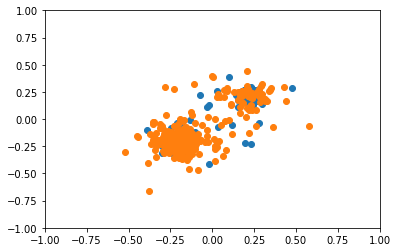

epoch: 400, train cost_P 2.581166, train cost: 1.606601, test cost: 1.603514, minimum test cost: 1.603514
means of test groups: tensor([[3.8358],
        [4.4483],
        [5.0485],
        [4.1502],
        [5.0854]], device='cuda:0')
ratings of test groups: tensor([5., 4., 4., 4., 5.])


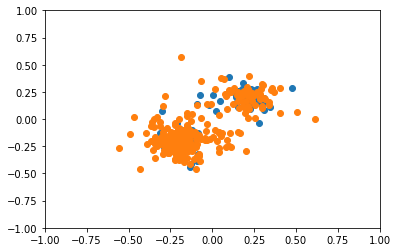

epoch: 500, train cost_P 2.328152, train cost: 1.525828, test cost: 1.524164, minimum test cost: 1.524164
means of test groups: tensor([[4.1772],
        [5.1526],
        [3.2302],
        [3.5476],
        [3.6854]], device='cuda:0')
ratings of test groups: tensor([2., 3., 5., 4., 3.])


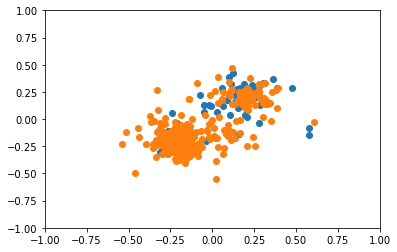

epoch: 600, train cost_P 2.125579, train cost: 1.457937, test cost: 1.457642, minimum test cost: 1.457642
means of test groups: tensor([[3.8454],
        [3.3868],
        [4.4254],
        [3.3713],
        [4.0897]], device='cuda:0')
ratings of test groups: tensor([4., 3., 4., 3., 4.])


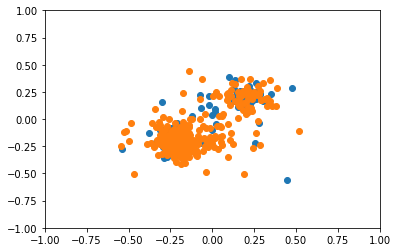

epoch: 700, train cost_P 1.961522, train cost: 1.400544, test cost: 1.401515, minimum test cost: 1.401515
means of test groups: tensor([[4.2334],
        [4.7929],
        [4.2036],
        [4.3764],
        [3.8588]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 5., 4.])


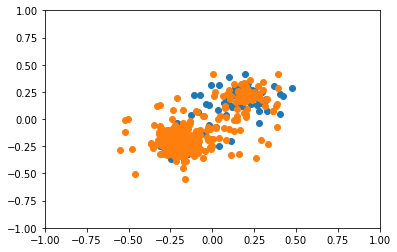

epoch: 800, train cost_P 1.826957, train cost: 1.351650, test cost: 1.353780, minimum test cost: 1.353780
means of test groups: tensor([[2.8106],
        [3.0771],
        [4.8778],
        [6.7816],
        [4.0547]], device='cuda:0')
ratings of test groups: tensor([2., 3., 2., 5., 3.])


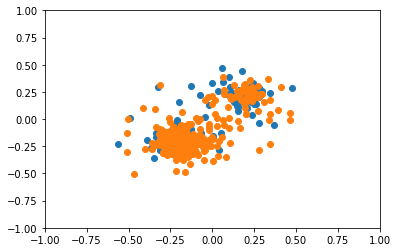

epoch: 900, train cost_P 1.715140, train cost: 1.309633, test cost: 1.312820, minimum test cost: 1.312820
means of test groups: tensor([[3.3497],
        [3.7156],
        [3.6906],
        [3.4263],
        [3.4652]], device='cuda:0')
ratings of test groups: tensor([1., 5., 4., 4., 4.])


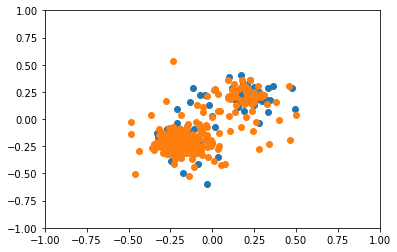

epoch: 1000, train cost_P 1.621306, train cost: 1.273305, test cost: 1.277441, minimum test cost: 1.277441
means of test groups: tensor([[3.8960],
        [2.6377],
        [4.1620],
        [2.8873],
        [6.5823]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 3., 4.])


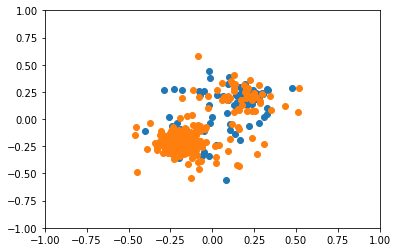

epoch: 1100, train cost_P 1.541780, train cost: 1.241684, test cost: 1.246661, minimum test cost: 1.246661
means of test groups: tensor([[3.7360],
        [4.6370],
        [3.8565],
        [3.4979],
        [4.0009]], device='cuda:0')
ratings of test groups: tensor([5., 3., 5., 2., 3.])


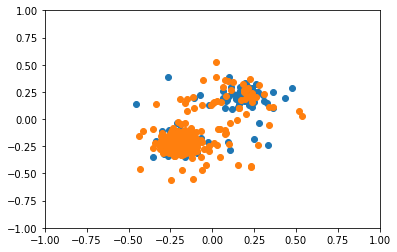

epoch: 1200, train cost_P 1.473622, train cost: 1.213928, test cost: 1.219635, minimum test cost: 1.219635
means of test groups: tensor([[5.2068],
        [3.8291],
        [4.7328],
        [4.6056],
        [6.2366]], device='cuda:0')
ratings of test groups: tensor([4., 4., 4., 4., 3.])


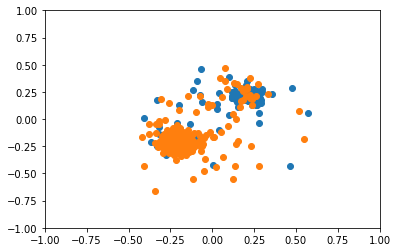

epoch: 1300, train cost_P 1.414698, train cost: 1.189411, test cost: 1.195752, minimum test cost: 1.195752
means of test groups: tensor([[3.4251],
        [3.1663],
        [4.0309],
        [3.7131],
        [3.1939]], device='cuda:0')
ratings of test groups: tensor([4., 5., 4., 2., 5.])


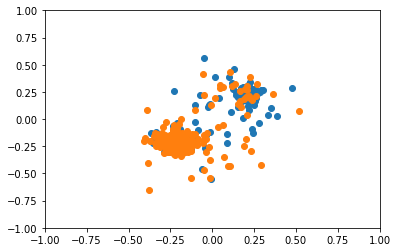

epoch: 1400, train cost_P 1.363341, train cost: 1.167622, test cost: 1.174523, minimum test cost: 1.174523
means of test groups: tensor([[4.4809],
        [3.1506],
        [3.6072],
        [5.8433],
        [4.4392]], device='cuda:0')
ratings of test groups: tensor([5., 4., 4., 3., 5.])


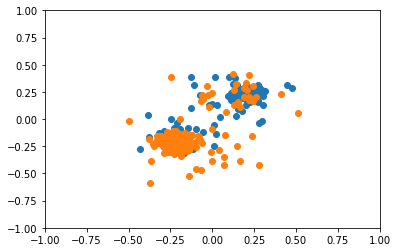

epoch: 1500, train cost_P 1.318300, train cost: 1.148172, test cost: 1.155564, minimum test cost: 1.155564
means of test groups: tensor([[3.5387],
        [4.6358],
        [3.4458],
        [3.5126],
        [4.1057]], device='cuda:0')
ratings of test groups: tensor([4., 5., 3., 4., 5.])


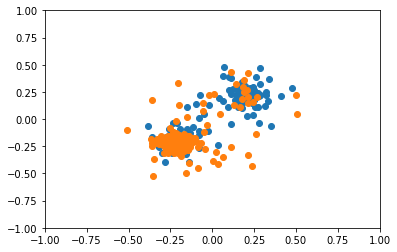

epoch: 1600, train cost_P 1.278462, train cost: 1.130691, test cost: 1.138508, minimum test cost: 1.138508
means of test groups: tensor([[3.4034],
        [3.8939],
        [3.2651],
        [2.7810],
        [3.3714]], device='cuda:0')
ratings of test groups: tensor([3., 4., 2., 2., 4.])


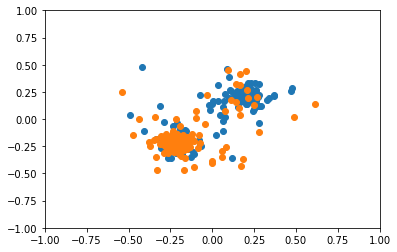

epoch: 1700, train cost_P 1.242982, train cost: 1.114891, test cost: 1.123077, minimum test cost: 1.123077
means of test groups: tensor([[3.2642],
        [3.7194],
        [2.8485],
        [3.7107],
        [2.9196]], device='cuda:0')
ratings of test groups: tensor([3., 2., 1., 4., 3.])


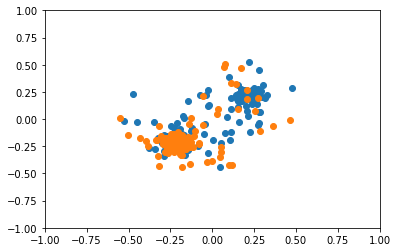

epoch: 1800, train cost_P 1.211195, train cost: 1.100543, test cost: 1.109062, minimum test cost: 1.109062
means of test groups: tensor([[3.5979],
        [3.5717],
        [3.8773],
        [3.3740],
        [2.4235]], device='cuda:0')
ratings of test groups: tensor([3., 4., 5., 4., 1.])


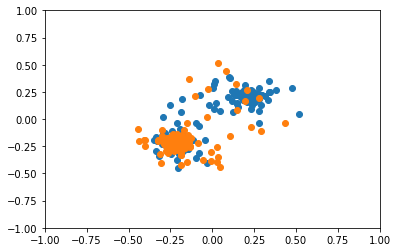

epoch: 1900, train cost_P 1.182619, train cost: 1.087483, test cost: 1.096291, minimum test cost: 1.096291
means of test groups: tensor([[3.0686],
        [4.6620],
        [4.6463],
        [4.3980],
        [3.5725]], device='cuda:0')
ratings of test groups: tensor([3., 4., 4., 3., 2.])


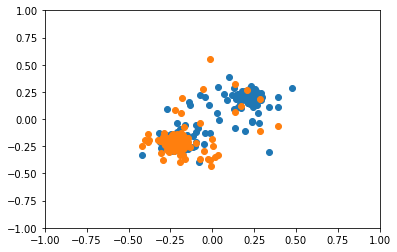

KeyboardInterrupt: 

In [29]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
#optimizer_Q = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
scheduler_P = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_P, T_0 = 10, eta_min = 0.001, last_epoch = -1)
#scheduler_Q = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_Q, T_0 = 10, eta_min = 0.001, last_epoch = -1)


X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []

for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
    hypothesis_mean_p = (mean + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device) + Q[users].sum(axis = 1) * pnu).unsqueeze(1)
    
    cost_P = F.mse_loss(hypothesis_mean_p, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward(retain_graph = True)
    optimizer_P.step()
    scheduler_P.step()

#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) 
#     hypothesis_mean_q = (mean + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device) + Q[users].sum(axis = 1) * pnu).unsqueeze(1)
    
#     cost_Q = F.mse_loss(hypothesis_mean_q, ratings.unsqueeze(1).to(device))

#     optimizer_Q.zero_grad()
#     cost_Q.backward()
#     optimizer_Q.step()
#     scheduler_Q.step()
    
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
        
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
#        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1))                 
        hypo_test_mean = (mean + (torch.abs(bi[items_test]) + torch.abs(bu[users_test])).to(device) + Q[users_test].sum(axis = 1) * pnu_test).unsqueeze(1)
    
          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean_p, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)
        
        cost_list.append(cost)
        cost_test_list.append(cost_test)

    if epoch % 100 == 0:
        idx = np.random.choice(100020, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        hypo_test.append(hypo_test_mean[idx])
        true_rating.append(ratings_test[idx])
        idx_list.append(idx)
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
optimizer_Q = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
scheduler_P = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_P, T_0 = 10, eta_min = 0.001, last_epoch = -1)
scheduler_Q = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_Q, T_0 = 10, eta_min = 0.001, last_epoch = -1)


X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []

for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)
                        
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    scheduler_P.step()

#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) 
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)
                        
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    optimizer_Q.step()

    
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
        
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
#        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1))                 
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items_test]) + torch.abs(bu[users_test])).to(device).unsqueeze(1)                

          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)
        
        cost_list.append(cost)
        cost_test_list.append(cost_test)

    if epoch % 100 == 0:
        idx = np.random.choice(100020, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        hypo_test.append(hypo_test_mean[idx])
        true_rating.append(ratings_test[idx])
        idx_list.append(idx)
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:
# 0.842125 : alternative    0.845448
# 0.842694: both

# rank 30 : 0.8465
# rank 15 : 0.84715
# rank 13 : 0.84846
# rank 14 : 0.84767
# rank 12 : 0.846764
# rank 25 : 0.846917
# rank 27 : 0.846639
# rank 10 : 0.848631
# rank 17 : 0.846474
# rank 19 : 0.846425
# rank 22 : 0.84524
# rank 21 : 0.84554

In [ ]:
X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []

In [30]:
len(cost_list), len(cost_test_list)

(1958, 1958)

In [31]:
len(X), len(Y_test)

(1958, 1958)

In [32]:
len(hypo_test), len(true_rating)

(20, 20)

In [33]:
X2 = X[:11876]
Y_test2 = Y_test[:11876]

In [34]:
cost_list2 = cost_list[:11866]
cost_test_list2 = cost_list[:11876]

In [37]:
tr = []
tr_sort = []
for i in range(len(true_rating)):
    trc = true_rating[i].to(device)
    tr.append(trc)
for j in range(len(tr)):
    trs = tr[j].sort(descending = True)[0]
    tr_sort.append(trs)

In [38]:
ndcg_list = []
idcg_list = []
dcg_list = []
for r in tqdm(range(len(hypo_test))):
    for i in range(5):
        idcg = tr_sort[r][i] / np.log2(i+1 + 1)
        idcg_list.append(idcg)
        sum_idcg = sum(idcg_list)
    for j in range(5):
        dcg = hypo_test[r][j] / np.log2(j+1 + 1)
        dcg_list.append(dcg)
        sum_dcg = sum(dcg_list)
    
    ndcg = sum_dcg / sum_idcg
    ndcg_list.append(ndcg)

100%|██████████| 20/20 [00:00<00:00, 279.03it/s]


In [39]:
nd = []
ct = []
cl = []
for i in range(len(ndcg_list)):
    nds = ndcg_list[i].tolist()
    nd.append(nds)
for j in range(len(cost_test_list2)):
    cts = cost_test_list2[j].tolist()
    ct.append(cts)
for k in range(len(cost_list2)):
    cls = cost_list2[k].tolist()
    cl.append(cls)

In [40]:
nd2 = nd[:119]

In [41]:
import matplotlib.pyplot as plt

In [42]:
epochs = [i for i in range(0, 119)]

ValueError: x and y must have same first dimension, but have shapes (119,) and (20, 1)

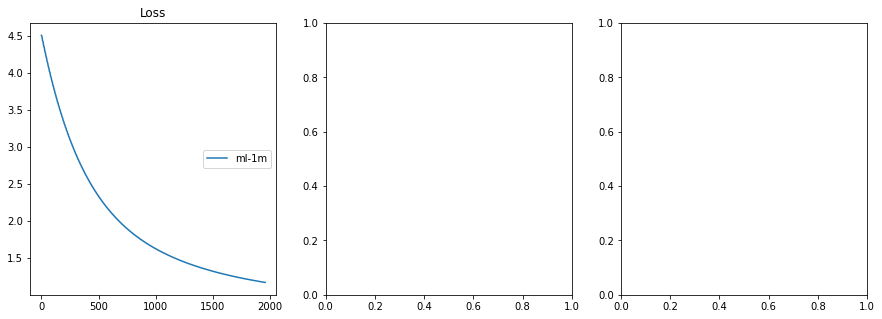

In [43]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax = ax.flatten()

ax[0].plot(X2, ct, label = 'ml-1m')
#ax[0].plot(X2, cl, label = 'ml-100k2')
ax[0].set_title('Loss')
ax[0].legend(loc = 7)

ax[1].plot(epochs, nd2, label = 'ml-1m')
ax[1].set_title('NDCG@5')
ax[1].legend(loc = 7)

ax[2].plot(X2, Y_test2, label = 'ml-1m')
ax[2].set_title('RMSE')
ax[2].legend(loc = 5 )
plt.show()

In [44]:
import csv

In [45]:
len(X2)

1958

In [46]:
y_epoch = [i for i in range(0, 1958)]

In [ ]:
y_epoch = [i for i in range(0, 11876)]

In [50]:
with open("1m_svdplusplus_Y_test.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([Y_test2])

In [51]:
with open("1m_svdplusplus_ndcg.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(epochs)
        writer.writerows(nd2)

In [52]:
with open("1m_normsvdplusplus_cost_test_list.csv", 'w', newline = '')  as file:
        writer = csv.writer(file)
        writer.writerow(y_epoch)
        writer.writerows([ct])

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
loss_total

In [ ]:
ratings.to(device)

In [ ]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
optimizer_Q = torch.optim.Adam([P, Q, bi, bu] + list(layers_mean.parameters()), lr= 1e-4)
scheduler_P = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_P, T_0 = 10, eta_min = 0.001, last_epoch = -1)
scheduler_Q = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer_Q, T_0 = 10, eta_min = 0.001, last_epoch = -1)


X = []
Y = []
Y_test = []
hypo_test = []
true_rating = []
idx_list = []
cost_list = []
cost_test_list = []
loss_total = []

for epoch in range(100000):
    for i in range(37):
        for j in range(64):
            if np.isnan(R[i,j]) == False:
                eij = (R[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + float(y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)))
                bu[i] = bu[i] + lr_bias*(eij - regular_bias * bu[i])
                bi[j] = bi[j] + lr_bias*(eij - regular_bias * bi[j])
                P[i] = P[i] + lr * (eij * Q[j] - regular * P[i])
                Q[j] = Q[j] + lr * (eij * (P[i] + (y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)) - regular * Q[j])
                Y[j] = Y[j] + lr * (eij * y_norm[i] * Q[j] - regular * Y[j])
                            
    loss_iter = 0
    for i in range(37):
        for j in range(64):
            if np.isnan(R[i,j]) == False:
                p_nrm = torch.linalg.norm(P[i])**2
                q_nrm = torch.linalg.norm(Q[j])**2
                y_nrm = torch.linalg.norm(Y[train_r2[i] == 1], axis=1)**2
                loss_iter += (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + y_norm[i] * torch.sum(Y[train_r2[i] == 1], axis=0)))**2 \
                                  + regular * (p_nrm + q_nrm + torch.sum(y_nrm)) + regular_bias * (bu[i]**2 + bi[j]**2)
    loss_total.append(loss_iter)    

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1))  + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)
                        
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    scheduler_P.step()

#    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) 
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items]) + torch.abs(bu[users])).to(device).unsqueeze(1)
                        
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    optimizer_Q.step()

    
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
#        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1))                 
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (torch.abs(bi[items_test]) + torch.abs(bu[users_test])).to(device).unsqueeze(1)                

          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)
        
        cost_list.append(cost)
        cost_test_list.append(cost_test)

    if epoch % 100 == 0:
        idx = np.random.choice(100020, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        hypo_test.append(hypo_test_mean[idx])
        true_rating.append(ratings_test[idx])
        idx_list.append(idx)
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:

# mu = torch.nn.Parameter(torch.randn(1, n_gaussians, requires_grad=True).to(device))
# log_std = torch.nn.Parameter(torch.abs(torch.randn(1, n_gaussians, requires_grad=True)).to(device))


lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.1
optimizer_P = torch.optim.Adam([P] + list(layers_mean.parameters()), lr= 1e-3)
optimizer_Q = torch.optim.Adam([Q] + list(layers_mean.parameters()), lr= 1e-3)



X = []
Y = []
Y_test = []


for i in range(3705):
    for j in range(6039):
        if np.isnan(R[i,j]) == False:
            eij = (R[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + float(y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)))
            bu[i] = bu[i] + lr_bias*(eij - regular_bias * bu[i])
            bi[j] = bi[j] + lr_bias*(eij - regular_bias * bi[j])
            P[i] = P[i] + lr * (eij * Q[j] - regular * P[i])
            Q[j] = Q[j] + lr * (eij * (P[i] + (y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)) - regular * Q[j])
            Y[j] = Y[j] + lr * (eij * y_norm[i] * Q[j] - regular * Y[j])




for epoch in range(100000):

  # 가설 = 예상별점(아이템벡터와 유저벡터 내적) + 전체평점평균 + 아이템벡터의 bias + 유저벡터의 bias
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items].cuda() + bias_user[users].cuda()).unsqueeze(1)
                        
    cost_P = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))                                                                                                        
    
  # 기울기 계산
    optimizer_P.zero_grad()
    cost_P.backward()
    optimizer_P.step()
    
    hypothesis_mean = layers_mean(P[items] / torch.sqrt(torch.sum(P[items]**2, axis= 1)).unsqueeze(1) * Q[users] / torch.sqrt(torch.sum(Q[users]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items].cuda() + bias_user[users].cuda()).unsqueeze(1)
                        
    cost_Q = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))

    optimizer_Q.zero_grad()
    cost_Q.backward()
    optimizer_Q.step()
    
  # 기울기 계산 필요 없다.
    with torch.no_grad():
              # 만들어진 P, Q matrix로 예측값을 뽑아내고 검증데이터와 비교한다.

              # 가설 = 예상별점(아이템벡터와 유저벡터 내적)
        hypo_test_mean = layers_mean(P[items_test] / torch.sqrt(torch.sum(P[items_test]**2, axis= 1)).unsqueeze(1) * Q[users_test] / torch.sqrt(torch.sum(Q[users_test]**2, axis= 1)).unsqueeze(1)) + (mean + bias_item[items_test].cuda() + bias_user[users_test].cuda()).unsqueeze(1)                          
          # 비용 = MSE items_test items_test
        cost = F.mse_loss(hypothesis_mean, ratings.unsqueeze(1).to(device))
        cost_test = F.mse_loss(hypo_test_mean, ratings_test.unsqueeze(1).to(device))
        X.append(epoch)

        Y_test.append(cost_test.item() ** 0.5)

    if epoch % 100 == 0:
        idx = np.random.choice(100020, 5, replace=False)
        print("epoch: {}, train cost_P {:6f}, train cost_Q: {:.6f}, train cost: {:.6f}, test cost: {:.6f}, minimum test cost: {:.6f}" .format(epoch, cost_P.item() , cost_Q.item(), cost.item() ** 0.5, cost_test.item() ** 0.5, np.min(Y_test)))
        print("=================================================================================")
        print('means of test groups:', hypo_test_mean[idx])
        print('ratings of test groups:', ratings_test[idx])
        print("=================================================================================")
        
        PP = P / torch.sqrt(torch.sum(P**2, axis = 1)).unsqueeze(1)
        QQ = Q / torch.sqrt(torch.sum(Q**2, axis = 1)).unsqueeze(1)
        plt.scatter(PP.detach().cpu().numpy()[:,0], PP.detach().cpu().numpy()[:,1])
        plt.scatter(QQ.detach().cpu().numpy()[:,0], QQ.detach().cpu().numpy()[:,1])
        plt.xlim((-1,1))
        plt.ylim((-1,1))
        plt.show()
        
        

In [ ]:
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

In [ ]:
mean = (ratings.sum()/len(ratings)).item()

In [ ]:
R = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
pd.DataFrame(pow(np.sum()))

In [ ]:
train_1 = pd.read_csv('../ml-100k/ua.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_1 = pd.read_csv('../ml-100k/ua.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
train_2 = pd.read_csv('../ml-100k/ub.base',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])
test_2 = pd.read_csv('../ml-100k/ub.test',sep='\t', header=None, names=['userId', 'itemId', 'rating','timestamp'])

In [ ]:
train_ratings = train_1.userId.count()
test_ratings = test_1.userId.count()
train_frac = train_ratings/(train_ratings+test_ratings)*100
print(f'Train/test split is: {train_frac, 100-train_frac}')

In [ ]:
R_train1 = pd.pivot_table(train_1, values='rating', index='userId', columns='itemId')
R_test1 = pd.pivot_table(test_1, values='rating', index='userId', columns='itemId')

In [ ]:
R_train1.shape, R_test1.shape

In [ ]:
F = R_train1.copy()

for i in F.index:
    for j in F.columns:
        if np.isnan(F.loc[i,j]) == True:
            F.loc[i,j] = 0
        elif np.isnan(F.loc[i,j]) == False:
            F.loc[i,j] = 1
        else: continue

In [ ]:
F.head()

In [ ]:
print(np.mean(np.nanmean(R_train1, axis=0)))
print(np.mean(np.nanmean(R_train1, axis=1)))

In [ ]:
count = 0
r_sum = 0

for i in R_train1.index:
    for j in R_train1.columns:
        if np.isnan(R_train1.loc[i,j]) == False:
            count += 1
            r_sum += R_train1.loc[i,j]
        else: continue

mu = r_sum/count

In [ ]:
print(f'The global mean/bias for our matrix is: {mu}')


In [ ]:
bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad = True)

In [ ]:
n = len(R_train1.index)
m = len(R_train1.columns)

In [ ]:
Bu1 = pd.DataFrame(np.random.rand(n), index= R_train1.index) 
Bi1 = pd.DataFrame(np.random.rand(m), index= R_train1.columns)

In [ ]:
P1 = pd.DataFrame(np.random.rand(n,10), index=R_train1.index)
Q1 = pd.DataFrame(np.random.rand(m,10), index=R_train1.columns)
Y1 = pd.DataFrame(np.random.rand(m,10), index=R_train1.columns)

In [ ]:
P1.shape, Q1.shape, Y1.shape

In [ ]:
train_r1 = np.where(train_r == 0, 0, 1)

In [ ]:
train_r2 = torch.from_numpy(train_r1)

In [ ]:
numItems = items.max() + 1
numUsers = users.max() + 1
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
P.shape, Q.shape, Y.shape

In [ ]:
mean = (ratings.sum()/len(ratings)).item()

In [ ]:
y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2)

In [ ]:
def SVDplusplus(R, mean, rank, steps, lr, regular, lr_bias, regular_bias):
    
    '''
    R : train_r
    rank = 20
    lr = learning_rate
    '''
    
    rank = rank
    #get the dimentions of R
    n = train_r.shape[0]
    m = train_r.shape[1]
    
    numItems = items.max() + 1
    numUsers = users.max() + 1
    
    #initialize the user, item and global bias
    bias_item = torch.randn(numItems, requires_grad = True)
    bias_user = torch.randn(numUsers, requires_grad = True)
    mean = mean
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
    Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    
    #precalculate implicit feedback metrics
    train_r1 = np.where(train_r == 0, 0, 1)
    train_r2 = torch.from_numpy(train_r1)
    
    y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2)
        
    loss_total = []
    
    for s in range(steps):
        print(f'Iteration {s} started')
        for i in range(R.shape[0]):
            for j in range(R.shape[1]):
                if np.isnan(R[i,j]) == False:
                    eij = (R[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + float(y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)))
                    bu[i] = bu[i] + lr_bias*(eij - regular_bias * bu[i])
                    bi[j] = bi[j] + lr_bias*(eij - regular_bias * bi[j])
                    P[i] = P[i] + lr * (eij * Q[j] - regular * P[i])
                    Q[j] = Q[j] + lr * (eij * (P[i] + (y_norm[i]) * torch.sum(Y[R[i] == 1], axis=0)) - regular * Q[j])
                    Y[j] = Y[j] + lr * (eij * y_norm[i] * Q[j] - regular * Y[j])
                    
        loss_iter = 0
        for i in range(train_r2.shape[0]):
            for j in range(train_r2.shape[1]):
                if np.isnan(R[i,j]) == False:
                    p_nrm = torch.linalg.norm(P[i])**2
                    q_nrm = torch.linalg.norm(Q[j])**2
                    y_nrm = torch.linalg.norm(Y[train_r2[i] == 1], axis=1)**2
                    loss_iter += (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + y_norm[i] * torch.sum(Y[train_r2[i] == 1], axis=0)))**2 \
                                  + regular * (p_nrm + q_nrm + torch.sum(y_nrm)) + regular_bias * (bu[i]**2 + bi[j]**2)
        loss_total.append(loss_iter)
        print(f'Iteration: {s} \t Loss: {loss_total[-1]}')            
    
    return P, Q, Y, bu, bi, loss_total            

In [ ]:
train_r.shape

In [ ]:
P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)

In [ ]:
SVDplusplus(train_r, mean, 15, 2, 0.02, 0.1, 0.01, 0.007)

In [ ]:
SVDplusplus(R_train1, mu, 15, 2, 0.02, 0.1, 0.01, 0.007)
SVDplusplus(R, mean, rank, steps, lr, regular, lr_bias, regular_bias)

In [ ]:
train_r2.shape

In [ ]:
def SVDplusplus(R, mean, rank, steps, lr, regular, lr_bias, regular_bias):
    
    '''
    R : train_r
    rank = 20
    lr = learning_rate
    '''
    
    rank = rank
    #get the dimentions of R
    n = train_r.shape[0]
    m = train_r.shape[1]
    
    numItems = items.max() + 1
    numUsers = users.max() + 1
    
    #initialize the user, item and global bias
    bias_item = torch.randn(numItems, requires_grad = True)
    bias_user = torch.randn(numUsers, requires_grad = True)
    mean = mean
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numItems, rank)).to(device), requires_grad=True)
    Q = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    Y = torch.nn.Parameter(torch.nn.init.orthogonal_(torch.empty(numUsers, rank)).to(device), requires_grad=True)
    
    #precalculate implicit feedback metrics
    train_r1 = np.where(train_r == 0, 0, 1)
    train_r2 = torch.from_numpy(train_r1)
    
    y_norm = torch.pow(torch.sum(train_r2, axis=0), -1/2)
        
    loss_total = []

In [ ]:
lr = 0.01
regular = 0.1
lr_bias = 0.01
regular_bias = 0.001

eij = []
for i in range(3706):
    for j in range(6040):
        if np.isnan(train_r2[i,j]) == False:
            eij = (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + float(y_norm[i]) * torch.sum(Y[train_r1[i] == 1], axis=0)))
            bu[i] = bu[i] + lr_bias*(eij - regular_bias * bu[i])
            bi[j] = bi[j] + lr_bias*(eij - regular_bias * bi[j])
            P[i] = P[i] + lr * (eij * Q[j] - regular * P[i])
            Q[j] = Q[j] + lr * (eij * (P[i] + (y_norm[i]) * torch.sum(Y[train_r2[i] == 1], axis=0)) - regular * Q[j])
            Y[j] = Y[j] + lr * (eij * y_norm[i] * Q[j] - regular * Y[j])
                    
#     loss_iter = 0
#     for i in range(train_r2.shape[0]-1):
#         for j in range(train_r2.shape[1]-1):
#             if np.isnan(train_r2[i,j]) == False:
#                 p_nrm = torch.linalg.norm(P[i])**2
#                 q_nrm = torch.linalg.norm(Q[j])**2
#                 y_nrm = torch.linalg.norm(Y[train_r2[i] == 1], axis=1)**2
#                 loss_iter += (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + y_norm[i] * torch.sum(Y[train_r2[i] == 1], axis=0)))**2 \
#                                   + regular * (p_nrm + q_nrm + torch.sum(y_nrm)) + regular_bias * (bu[i]**2 + bi[j]**2)
#     loss_total2.append(loss_iter)
#     print(f'Iteration: {s} \t Loss: {loss_total[-1]}')

In [ ]:
loss_totla2 = []
for i in range(train_r2.shape[0]):
    for j in range(train_r2.shape[1]):
        if np.isnan(train_r2[i,j]) == False:
            eij = (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + float(y_norm[i]) * torch.sum(Y[train_r2[i] == 1], axis=0)))
            bu[i] = bu[i] + lr_bias*(eij - regular_bias * bu[i])
            bi[j] = bi[j] + lr_bias*(eij - regular_bias * bi[j])
            P[i] = P[i] + lr * (eij * Q[j] - regular * P[i])
            Q[j] = Q[j] + lr * (eij * (P[i] + (y_norm[i]) * torch.sum(Y[train_r2[i] == 1], axis=0)) - regular * Q[j])
            Y[j] = Y[j] + lr * (eij * y_norm[i] * Q[j] - regular * Y[j])

    loss_iter = 0
for i in range(train_r2.shape[0]):
    for j in range(train_r2.shape[1]):
        if np.isnan(train_r2[i,j]) == False:
            p_nrm = torch.linalg.norm(P[i])**2
            q_nrm = torch.linalg.norm(Q[j])**2
            y_nrm = torch.linalg.norm(Y[train_r2[i] == 1], axis=1)**2
            loss_iter += (train_r2[i,j] - mean - bu[i] - bi[j] - torch.dot(Q[j], P[i] + y_norm[i] * torch.sum(Y[train_r2[i] == 1], axis=0)))**2 \
                                  + regular * (p_nrm + q_nrm + torch.sum(y_nrm)) + regular_bias * (bu[i]**2 + bi[j]**2)
loss_total2.append(loss_iter)
print(f'Iteration: {s} \t Loss: {loss_total[-1]}')

In [ ]:
Q.shape, P.shape

In [ ]:
train_r2.shape

In [ ]:
train_r2[0,0] - mean - bu[0] - bi[0] - torch.dot(Q[0], P[0] + float(y_norm[0]) * torch.sum(Y[train_r2[0] == 1], axis = 0))

In [ ]:
Q1.shape, P1.shape

In [ ]:
len(R_train1.index), len(R_train1.columns)

In [ ]:
def SVDplusplus(R, F, mu, factors, steps, lrn_rate, regular, lrn_rate_bias, regular_bias):
    
    #get the dimentions of R
    n = len(R.index)
    m = len(R.columns)
    
    #initialize the user, item and global bias
    Bu = pd.DataFrame(np.random.rand(n), index=R.index) 
    Bi = pd.DataFrame(np.random.rand(m), index=R.columns)
    mu = mu
    
    #initialize the user-factor, item-factor and feedback-factor matrices
    P = pd.DataFrame(np.random.rand(n,factors), index=R.index)
    Q = pd.DataFrame(np.random.rand(m,factors), index=R.columns)
    Y = pd.DataFrame(np.random.rand(m,factors), index=R.columns)
    
    #precalculate implicit feedback metrics
    y_norm = pd.DataFrame(pow(np.sum(F, axis=1), -1/2), index=F.index)
    
    loss_total = []
    
    for s in range(steps):
        print(f'Iteration {s} started')
        for i in train_r2.shape:
            for j in train_r2.shape[1]:
                if np.isnan(train_r2[i,j]) == False:
                                  
                    eij = (train_r2[i,j] 
                           - mean
                           - bu[i] 
                           - bi[j] 
                           - np.dot(Q.loc[j], P.loc[i] + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)))
                    
                    Bu.loc[i] = Bu.loc[i] + lrn_rate_bias*(eij - regular_bias*Bu.loc[i])
                    Bi.loc[j] = Bi.loc[j] + lrn_rate_bias*(eij - regular_bias*Bi.loc[j])
                    P.loc[i] = P.loc[i] + lrn_rate*(eij*Q.loc[j] - regular*P.loc[i])
                    Q.loc[j] = Q.loc[j] + lrn_rate*(eij*(P.loc[i] + (y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0))\
                                                    - regular*Q.loc[j])
                    Y.loc[j] = Y.loc[j] + lrn_rate*(eij*y_norm.loc[i]*Q.loc[j] - regular*Y.loc[j])
                    
                    #print our vars for debugging purposes
#                     print(f'''y_norm*Y_sum: \n {float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)} \n,
#                           P_i + y_norm*Y_sum: \n {P.loc[i] + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0)} \n,
#                           dot product: {np.dot(Q.loc[j], P.loc[i].array + float(y_norm.loc[i])*np.sum(Y[F.loc[i]==1], axis=0))}\n,
#                           eij: {eij} \n,
#                           Bu: {Bu.loc[i]} \n,
#                           Bi: {Bi.loc[j]} \n,
#                           Q_j: {Q.loc[j]} \n,
#                           P_i: {P.loc[i]} \n,
#                           Y_j: {Y.loc[j]} \n,
#                           Bu nan {np.sum(np.isnan(Bu))},
#                           Bi nan {np.sum(np.isnan(Bi))},
#                           P nan {np.sum(np.sum(np.isnan(P)))},
#                           Q nan {np.sum(np.sum(np.isnan(Q)))},
#                           Y nan {np.sum(np.sum(np.isnan(Y)))}''')
        
        #calculae the loss
        loss_iter = 0
        for i in R.index:
            for j in R.columns:
                if np.isnan(R.loc[i,j]) == False:
                    p_nrm = np.linalg.norm(P.loc[i])**2
                    q_nrm = np.linalg.norm(Q.loc[j])**2
                    y_nrm = np.linalg.norm(Y[F.loc[i]==1], axis=1)**2
                    loss_iter += (R.loc[i,j] 
                                  - mu 
                                  - Bu.loc[i] 
                                  - Bi.loc[j] 
                                  - np.dot(Q.loc[j], P.loc[i] + y_norm.loc[i]*np.sum(Y[F.loc[i]==1], axis=0)))**2 \
                                  + regular*(p_nrm + q_nrm + np.sum(y_nrm))\
                                  + regular_bias*(Bu.loc[i]**2 + Bi.loc[j]**2)
        loss_total.append(loss_iter)
        print(f'Iteration: {s} \t Loss: {loss_total[-1]}')            
    
    return P, Q, Y, Bu, Bi, loss_total

In [ ]:
P, Q, Y, Bu, Bi, loss = SVDplusplus(R_train1, F, mu, 15, 2, 0.02, 0.1, 0.01, 0.007)

In [ ]:
R_train1.index

In [ ]:
R_train1.columns

In [ ]:
F.loc[4] + F.loc[3]

In [ ]:
y_norm = pd.DataFrame(pow(np.sum(F, axis = 1), -1/2), index = F.index)

In [ ]:
np.sum(np.sum(np.isnan(P)))

In [ ]:
Bi = pd.DataFrame(np.random.rand(len(R_train1.columns)), index=R_train1.columns)
Bu = pd.DataFrame(np.random.rand(len(R_train1.index)), index=R_train1.index)
print(Bu.loc[943])
print (Bi.loc[4])
print(Bu.loc[943]+Bi.loc[4])

In [ ]:
counter = 0
se = 0
ae = 0

for i in R_test1.index:
    for j in R_test1.columns:
        if np.isnan(R_test1.loc[i,j]) == False:
            if j in Q.index == True:
                r_pred = (mu 
                          + Bu.loc[i]
                          + Bi.loc[j]
                          + np.dot(Q.loc[j], P.loc[i] + y_norm.loc[i]*np.sum(Y[F.loc[i]==1], axis=0)))
                se += (R_test1.loc[i,j] - r_pred)**2
                ae += np.abs(R_test1.loc[i,j] - r_pred)
                counter += 1
            elif j in Q.index == False:
                r_pred = mu + Bi[j]
                se += (R_test1.loc[i,j] - r_pred)**2
                ae += np.abs(R_test1.loc[i,j] - r_pred)
                counter += 1
            else: continue
    
rmse = (se/counter)**(1/2)
mae = ae/counter

print(f'The model RMSE: {rmse} \t The model MAE: {mae}')

In [ ]:
for current_epoch in range(n_epochs):
    print("processing epoch {}".format(current_epoch))
    for u, i, r in train_dataset.all_ratings():
        Nu = tra